### Predicting Stock Return with LSTM
#### Author:  Yifan Gao

## 1. Load Data

In [1]:
import pandas as pd
import pandas_datareader.data as web
import requests
import numpy as np
import warnings
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
warnings.filterwarnings("ignore")

# Feel free to replace with your own stock
ticker = 'FB'

train_start = dt.datetime(2012,1,1)
train_end = dt.datetime(2019,12,31)
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

# Yahoo Finance restricts access to their API so doing some tricks to bypass this
USER_AGENT = {
    'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
                   ' Chrome/91.0.4472.124 Safari/537.36')
    }
sesh = requests.Session()
sesh.headers.update(USER_AGENT)

df = web.DataReader(ticker, 'yahoo', train_start, train_end, session=sesh)
df_test = web.DataReader(ticker, 'yahoo', test_start, test_end, session=sesh)
combined_df = pd.concat((df['Adj Close'], df_test['Adj Close']), axis = 0)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))


Bad key "text.kerning_factor" on line 4 in
C:\Users\mars_\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## 2. Train the data with LSTM model

In [2]:
lookback_days = 60
X_train = []
y_train = []

for i in range(lookback_days, len(df_scaled)):
    X_train.append(df_scaled[i-lookback_days:i])
    y_train.append(df_scaled[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [3]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 2s 29ms/step - loss: 0.0198
Epoch 2/25
59/59 [==============================] - 2s 29ms/step - loss: 0.0041
Epoch 3/25
59/59 [==============================] - 2s 29ms/step - loss: 0.0040
Epoch 4/25
59/59 [==============================] - 2s 29ms/step - loss: 0.0036
Epoch 5/25
59/59 [==============================] - 2s 29ms/step - loss: 0.0039
Epoch 6/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0034
Epoch 7/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0027
Epoch 8/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0028
Epoch 9/25
59/59 [==============================] - 2s 31ms/step - loss: 0.0031
Epoch 10/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0025
Epoch 11/25
59/59 [==============================] - 2s 31ms/step - loss: 0.0028
Epoch 12/25
59/59 [==============================] - 2s 31ms/step - loss: 0.0025
Epoch 13/25
59/59 [==================

## 3. Predict stock price for the test period

In [4]:
test_inputs = combined_df[len(combined_df) - len(df_test) - lookback_days:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(lookback_days, len(test_inputs)):
    X_test.append(test_inputs[i-lookback_days:i])
X_test = np.array(X_test)

In [5]:
predict_price = lstm.predict(X_test)
predict_price = scaler.inverse_transform(predict_price)
real_price = df_test['Adj Close'].values

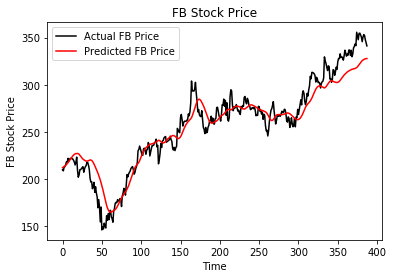

In [6]:
# Plot actuaL vs predicted price
plt.plot(real_price, color="black", label=f"Actual {ticker} Price")
plt.plot(predict_price, color="red", label=f"Predicted {ticker} Price")
plt.title(f"{ticker} Stock Price")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Stock Price")
plt.legend()
plt.show()

## 4. Predict next day stock price

In [7]:
# Predict next day price
nextday_df = [test_inputs[len(test_inputs) + 1 - lookback_days:len(test_inputs + 1)]]
nextday_df = np.array(nextday_df)
nextday_df = np.reshape(nextday_df, (nextday_df.shape[0], nextday_df.shape[1], 1))

In [8]:
nextday_price = lstm.predict(nextday_df)
nextday_price = scaler.inverse_transform(nextday_price)
print(f"The predicted price on next day for {ticker} is {nextday_price[0][0]}.")

The predicted price on next day for FB is 327.52606201171875.
